In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy
import csv

### Creating image datasets an data loaders for train and test using the experiments folder split

In [4]:
experiments_path = 'my_data/'
data_path = 'my_images/'
folder_names = ["with_mask_correct","with_mask_incorrect","without_mask"]

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [6]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [7]:
def create_data_files(experiments_path, data_path, train_percent):
    for folder in folder_names:
        print(os.listdir())
        images = [os.path.join(data_path+folder,f) for f in os.listdir(data_path+folder)]
        
        print("Number of images in {} = {}".format(data_path+folder,len(images)))
        #Write some images to the train folder
        with open(experiments_path+"/train.csv",'a') as file:
            for image in images[:round(len(images)*train_percent)]:
                shutil.copy(image,experiments_path +"/train" +"/"+ folder)

                
        #Write remaining images to test folder
        with open(experiments_path+"/test.csv",'a') as file:
            for image in images[round(len(images)*train_percent)+1:]:
                shutil.copy(image,experiments_path +"/test" +"/"+ folder)
                
    setup_csv_files(experiments_path,"train")
    setup_csv_files(experiments_path,"test")

In [8]:
def setup_csv_files(experiments_path, phase):
    with open(experiments_path+"/"+ phase +".csv",'w') as file:
        wr = csv.writer(file)
        wr.writerow(["filename","class"])
        for folder in folder_names:
            for image in os.listdir(os.path.join(experiments_path+"/"+ phase +"/"+folder)):
                wr.writerow([image,folder])

In [9]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    os.makedirs(test_dir)
    for folder in folder_names:
        train_dir_class = os.path.join(train_dir, folder)
        test_dir_class = os.path.join(test_dir, folder)
        os.makedirs(train_dir_class)
        os.makedirs(test_dir_class)
    
    create_data_files(experiments_path, data_path, 0.8)

X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [16]:
# TEMPORARY, for adding in a temporary larger test set

setup_csv_files(experiments_path,"test")

In [10]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [11]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 538
    Root location: my_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [18]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 259
    Root location: my_data/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

In [21]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fd2c1b054f0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fd2c1b05910>}

In [28]:
class_names = image_datasets['train'].classes

In [29]:
class_names

['with_mask_correct', 'with_mask_incorrect', 'without_mask']

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [31]:
device

device(type='cuda', index=0)

In [32]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}


### Visualizing images

In [33]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    

In [34]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

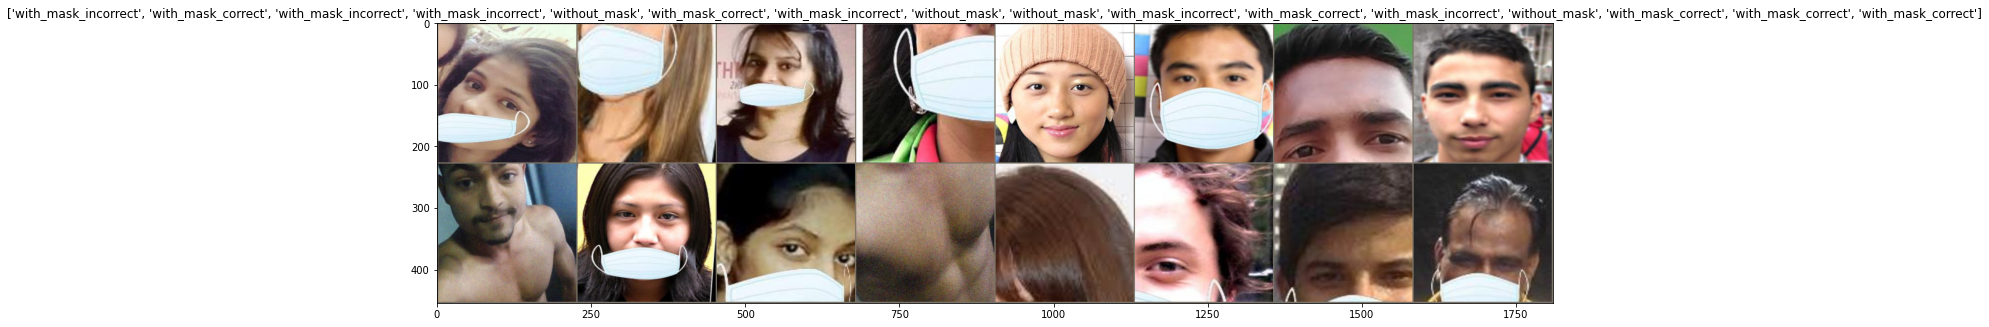

In [35]:
imshow(out, title=[class_names[x] for x in classes])

### Training the model

In [36]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model
                

In [37]:
import ssl


In [38]:
ssl._create_default_https_context = ssl._create_unverified_context

In [55]:


model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [56]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30)

Epoch 0/29
----------


/home/graham/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 0.6622 Acc:0.7249

test Loss: 0.6325 Acc:0.8069

Epoch 1/29
----------
train Loss: 0.3396 Acc:0.8717

test Loss: 0.4300 Acc:0.8610

Epoch 2/29
----------
train Loss: 0.2500 Acc:0.8829

test Loss: 0.6197 Acc:0.8301

Epoch 3/29
----------
train Loss: 0.2455 Acc:0.8829

test Loss: 0.4180 Acc:0.8610

Epoch 4/29
----------
train Loss: 0.2527 Acc:0.8922

test Loss: 0.4337 Acc:0.8764

Epoch 5/29
----------
train Loss: 0.1881 Acc:0.9201

test Loss: 0.5186 Acc:0.8494

Epoch 6/29
----------
train Loss: 0.1958 Acc:0.9071

test Loss: 0.5924 Acc:0.8263

Epoch 7/29
----------
train Loss: 0.1872 Acc:0.9182

test Loss: 0.5206 Acc:0.8494

Epoch 8/29
----------
train Loss: 0.1728 Acc:0.9201

test Loss: 0.7026 Acc:0.8301

Epoch 9/29
----------
train Loss: 0.1841 Acc:0.9219

test Loss: 0.6067 Acc:0.8533

Epoch 10/29
----------
train Loss: 0.1633 Acc:0.9238

test Loss: 0.6316 Acc:0.8378

Epoch 11/29
----------
train Loss: 0.1544 Acc:0.9275

test Loss: 0.6139 Acc:0.8456

Epoch 12/29
----------
t

In [45]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [24]:
if(model_ft == None):
    model_ft = torch.load('mask1_model_resnet101.pth')

In [22]:
device = torch.device("cpu")
model_ft.to(device)
model_ft.eval()
total_correct = 0
total_tested = 0
for inputs,labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)

    total_correct += torch.sum(preds == labels.data)
    total_tested += len(inputs.data)

print("Test acc: {} ({}/{})".format(float(total_correct)/float(total_tested),total_correct,total_tested))

Test acc: 0.9382239382239382 (243/259)


In [42]:
torch.save(model_ft, 'mask1_model_resnet101.pth')

In [46]:
visualize_model(model_ft)

tensor([1, 2, 0, 0, 2, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 2], device='cuda:0') predicitons
true: with_mask_incorrect predicted: with_mask_incorrect
true: without_mask predicted: without_mask
true: with_mask_correct predicted: with_mask_correct
true: with_mask_correct predicted: with_mask_correct
true: without_mask predicted: without_mask
true: with_mask_incorrect predicted: with_mask_correct


In [44]:
FOLDER = '6cat_val'
!wget "http://mmoviles.upv.es/mascarillas/{FOLDER}.zip"
!unzip -qq -n {FOLDER}.zip

--2021-12-10 13:52:44--  http://mmoviles.upv.es/mascarillas/6cat_val.zip
Resolving mmoviles.upv.es (mmoviles.upv.es)... 158.42.250.56
Connecting to mmoviles.upv.es (mmoviles.upv.es)|158.42.250.56|:80... connected.
HTTP request sent, awaiting response... 404 Not Found
2021-12-10 13:52:44 ERROR 404: Not Found.

unzip:  cannot find or open 6cat_val.zip, 6cat_val.zip.zip or 6cat_val.zip.ZIP.
